# Tutorial 5: Image degradation, Inverse filtering
Until now we have seen spatial and frequency domain simple filtering as a means to process images. We later saw how some nice properties of Fourier transform has enabled computed tomography. Then, we looked at different aspects of sampling, resampling images and saw the resulting affects of doing so, and learned how to alleviate them. 

Today, our agenda is to understand the formulation of image restoration problems. We will now see different kinds of degradations that can happen to an image and how to model them. Then, we will see a basic method to alleviate them. 

Agenda:
1. Additive noise
2. Poisson noise
3. Focal blur
4. Motion blur
5. Inverse filter

In [118]:
% matplotlib inline
import numpy as np
import cv2
from PIL import Image
from scipy.signal import convolve2d as conv2d
from matplotlib import pyplot as plt

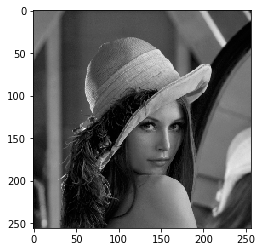

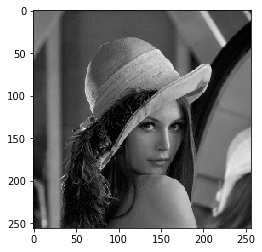

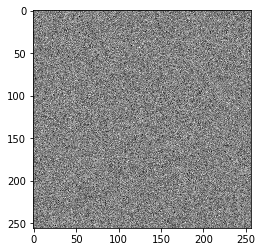

In [196]:
## Additive Gaussian Noise
image = cv2.imread('lena.jpg',0)
image = cv2.resize(image, (256, 256)) 


row,col = image.shape
scaled_img = (image - np.min(image))/np.max(image)

mean = 0
var = 0.9
sigma = var**0.5
gauss = np.random.normal(mean,sigma,(row,col))
gauss = gauss.reshape(row,col)
noisy = image + gauss

plt.figure()
plt.imshow(image)
plt.show()

plt.figure()
plt.imshow(noisy)
plt.show()

plt.figure()
plt.imshow(noisy-image)
plt.show()

### Salt and Pepper Noise

Can occur due to the use of faulty instruments.


/Users/sanketh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/Users/sanketh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()


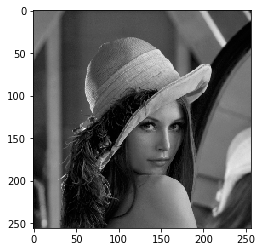

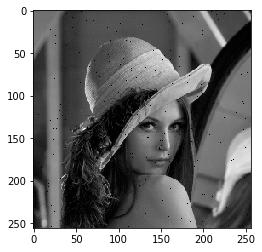

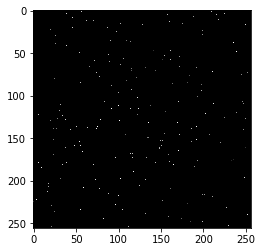

In [197]:
## Salt and Pepper Noise
row,col = image.shape
s_vs_p = 0.5
amount = 0.004
out = np.copy(image)
# Salt mode
num_salt = np.ceil(amount * image.size * s_vs_p)
coords = [np.random.randint(0, i - 1, int(num_salt))
      for i in image.shape]
out[coords] = 1

# Pepper mode
num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
coords = [np.random.randint(0, i - 1, int(num_pepper))
      for i in image.shape]
out[coords] = 0

plt.figure()
plt.imshow(image)
plt.show()

plt.figure()
plt.imshow(out)
plt.show()

plt.figure()
plt.imshow(out-image)
plt.show()

### Shot noise or Poisson noise

It is a discrete type of electronic noise which can be modeled as a poisson process. It arises due to discrete nature of the electric charge. It approximates well noise arising during the low-light condition.

<img src='Poisson-Noise.png' width="360">

$y[i]$ is an integer.

large $x[i] \to $ large $y[i]$

small $x[i] \to $ small $y[i]$

$x[i] = 0 \to y[i] = 0$ 


252
1.0
250.0


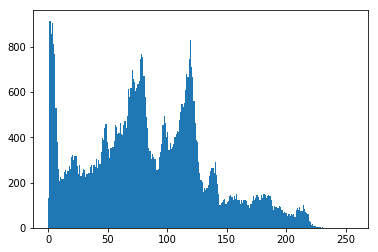

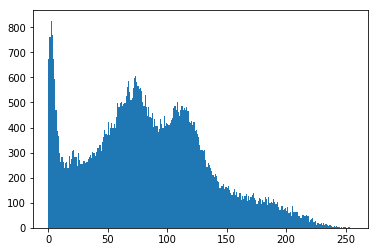

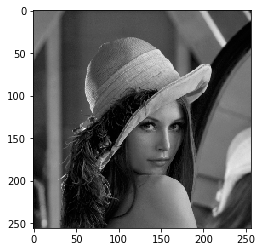

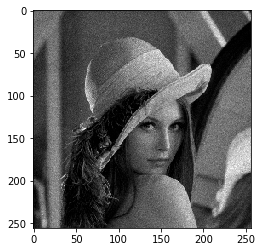

In [199]:
## Poisson noise
def add_poiss_noise_image(img):
    sy,sx = img.shape
    lambda_flat = np.reshape(img,[-1,1]).astype(np.float32)
    noisy_flat = np.random.poisson(lam=lambda_flat)
    noisy = np.reshape(noisy_flat,[sy,sx])
    return(noisy.astype(np.float32))

noise_peak = 250
max_val = np.amax(np.amax(image))
print(max_val)
scaled_img = image.astype(np.float32) * (1.0 / float(max_val))
print(np.max(scaled_img))
img_peak = (scaled_img)*float(noise_peak)
print(np.max(img_peak))

plt.hist(image.ravel(),256,[0,256]); plt.show()

poiss_noisy = add_poiss_noise_image(img_peak)  # noisy image

plt.hist(poiss_noisy.ravel(),256,[0,256]); plt.show()

plt.figure()
plt.imshow(image)
plt.show()

plt.figure()
plt.imshow(poiss_noisy)
plt.show()

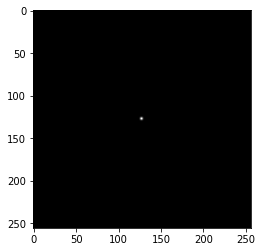

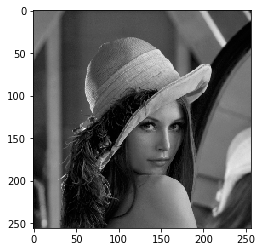

/Users/sanketh/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


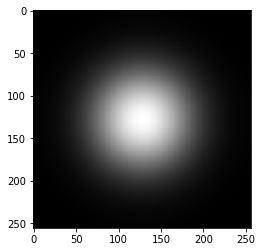

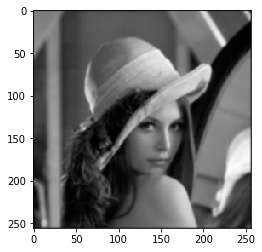

In [203]:
## Focal Blur
def gkern(l=5, sig=1.):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.arange(-l // 2 + 1., l // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sig**2))

    return kernel / np.sum(kernel)

psf = gkern(l=256, sig=1)

plt.figure()
plt.imshow(psf)
plt.show()


# apply spatially
fc_blur = conv2d(image, psf, 'same')

plt.figure()
plt.imshow(image)
plt.show()

# plt.figure()
# plt.imshow(psf)
# plt.show()

from scipy.fftpack import fft2, ifft2, ifftshift, fftshift
plt.figure()
plt.imshow(np.abs(fftshift(fft2(psf))))
plt.show()

plt.figure()
plt.imshow(fc_blur)
plt.show()

/Users/sanketh/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


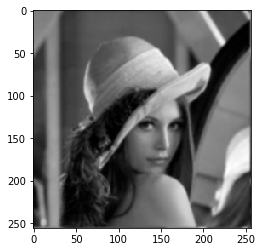

In [204]:
## FFT focal blur
fft_conved_img = fft2(psf)*fft2(image)
# blurring in frequency 
freq_blurred = ifftshift(ifft2(fft_conved_img))
plt.show()
plt.imshow(np.abs(freq_blurred))

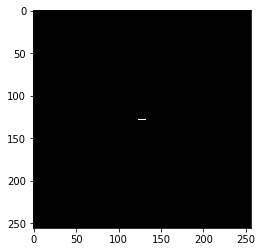

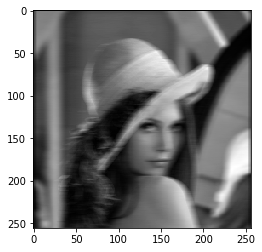

In [205]:
## Motion blur
def motion_process(leng, size):
    sx, sy = size
    PSF = numpy.zeros((sy, sx))
    PSF[int(sy / 2):int(sy /2 + 1), int(sx / 2 - leng / 2):int(sx / 2 + leng / 2)] = 1
    return PSF / PSF.sum()

motion_blur_psf = motion_process(10, image.shape)
#len = 300
sx, sy = image.shape
#print(motion_blur_psf[int(sy / 2):int(sy /2 + 1), int(sx / 2 - len / 2):int(sx / 2 + len / 2)])
plt.figure()
plt.imshow(motion_blur_psf)
plt.show()

img_motion_blur = conv2d(image, motion_blur_psf, 'same')
plt.figure()
plt.imshow(img_motion_blur)
plt.show()

/Users/sanketh/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


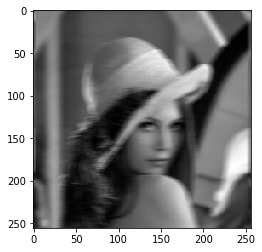

In [206]:
# FFT motion blur
fft_motion_conved_img = fft2(motion_blur_psf)*fft2(image)
# blurring in frequency 
freq_motion_blurred = ifftshift(ifft2(fft_motion_conved_img))
plt.show()
plt.imshow(np.abs(freq_motion_blurred))

## Blurring forward model

Let $I(x,y)$ be the clean image and $\hat{I}(x,y)$ be the blurred version, that is obtained by the blur PSF $H(x, y)$. For now, let us ignore the noise.

$$
\hat{I}(x,y) = H(x, y) \ast I(x, y) 
$$


Now, our goal is to recover underlying clean image $I(x, y)$ when we were given the noisy version of the image $\hat{I}(x, y)$ and the deformation model $H(x, y)$.

If we observe the same in the Fourier domain

$$
\hat{I}(u, v) = H(u, v) I(u, v)
$$

Ideally, if we were given the noisy image $\hat{I}(u, v)$ and the kernel $H(u, v)$, in order to get $I(u, v)$, we could do

$$
I(u, v) = \hat{I}(u,v) / H(u, v)
$$

This is called as "inverse filtering". Let's see how this performs.

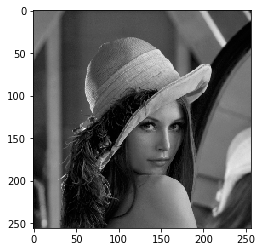

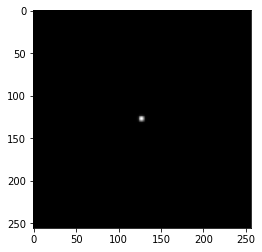

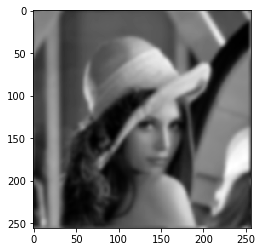

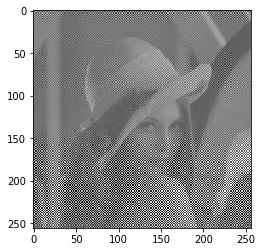

In [207]:
# We'll see this both for motion blur and focal blur

def gkern(l=5, sig=1.):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """
    ax = np.arange(-l // 2 + 1., l // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sig**2))
    return kernel / np.sum(kernel)

def motion_process(leng, size):
    sx, sy = size
    PSF = numpy.zeros((sy, sx))
    PSF[int(sy / 2):int(sy /2 + 1), int(sx / 2 - leng / 2):int(sx / 2 + leng / 2)] = 1
    return PSF / PSF.sum()

def make_blurred(inputs, PSF):
    input_fft = numpy.fft.fft2(inputs)
    PSF_fft = numpy.fft.fft2(PSF)
    blurred = numpy.fft.ifft2(input_fft * PSF_fft)
    blurred = numpy.abs(numpy.fft.fftshift(blurred))
    return blurred

def inverse_filter(inputs, PSF):
    input_fft = numpy.fft.fft2(inputs)
    PSF_fft = numpy.fft.fft2(PSF)
    input_fft_scaled = input_fft/input_fft.max()
    PSF_fft_scaled = PSF_fft/PSF_fft.max()
    recovered_fft_scaled = input_fft_scaled/PSF_fft_scaled
    recovered_fft = recovered_fft_scaled*input_fft.max()
    result = numpy.fft.ifft2(recovered_fft)
    result = numpy.real(numpy.fft.fftshift(result))
    return result


psf_focal_blur = gkern(l=256, sig=2.)

focal_blurred_image = make_blurred(image, psf_focal_blur)

deblurred_focal_image = inverse_filter(focal_blurred_image, psf_focal_blur)

plt.figure()
plt.imshow(image)
plt.show()

plt.figure()
plt.imshow(psf_focal_blur)
plt.show()

plt.figure()
plt.imshow(focal_blurred_image)
plt.show()

plt.figure()
plt.imshow(deblurred_focal_image)
plt.show()

/Users/sanketh/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


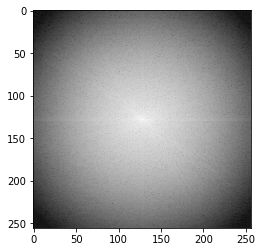

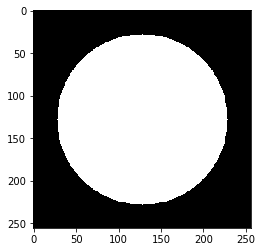

/Users/sanketh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


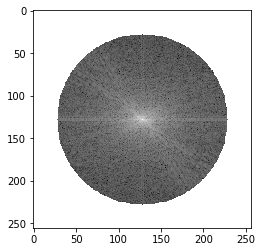

/Users/sanketh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


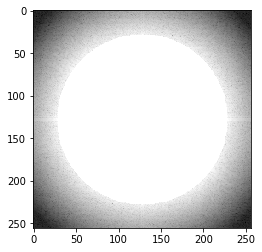

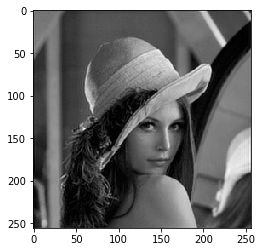

In [212]:
def truncated_inverse_filter(inputs, PSF):
    input_fft = fftshift(fft2(inputs))
    PSF_fft = fftshift(fft2(PSF))
    input_fft_scaled = input_fft/input_fft.max()
    plt.figure()
    plt.imshow(np.log(np.abs(input_fft_scaled)))
    plt.show()
    PSF_fft_scaled = PSF_fft/PSF_fft.max()
    recovered_fft_scaled = input_fft_scaled/PSF_fft_scaled
    recovered_fft = recovered_fft_scaled*input_fft.max()
    circle_img = np.zeros(input_fft.shape)
    cv2.circle(circle_img,(input_fft.shape[0]//2,input_fft.shape[1]//2),100,1,thickness=-1)
    plt.figure()
    plt.imshow(circle_img)
    plt.show()
    inner_recovered_fft = circle_img*recovered_fft
    plt.figure()
    plt.imshow(np.log(np.abs(inner_recovered_fft)))
    plt.show()
    circle_img = 1 - circle_img
    outer_input_fft = circle_img*input_fft
    result = ifftshift(ifft2(inner_recovered_fft+outer_input_fft))
    plt.figure()
    plt.imshow(np.log(np.abs(outer_input_fft)))
    plt.show()
    result = numpy.abs(result)
    return result

truncated_deblurred_focal_image = truncated_inverse_filter(focal_blurred_image, psf_focal_blur)

plt.figure()
plt.imshow(truncated_deblurred_focal_image)
plt.show()

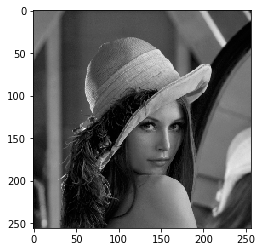

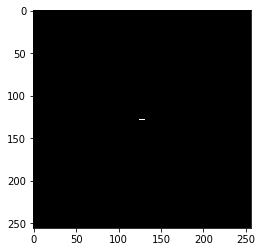

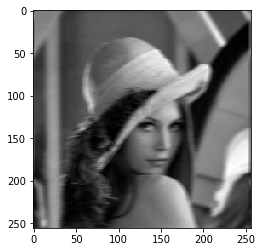

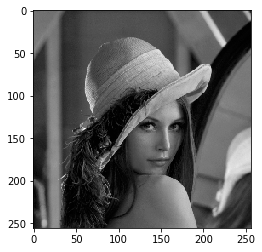

In [213]:
psf_motion_blur = motion_process(leng=7, size=image.shape)

motion_blurred_image = make_blurred(image, psf_motion_blur)

deblurred_motion_image = inverse_filter(motion_blurred_image, psf_motion_blur)

plt.figure()
plt.imshow(image)
plt.show()

plt.figure()
plt.imshow(psf_motion_blur)
plt.show()

plt.figure()
plt.imshow(motion_blurred_image)
plt.show()

plt.figure()
plt.imshow(deblurred_motion_image)
plt.show()

/Users/sanketh/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


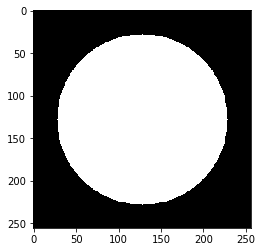

/Users/sanketh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


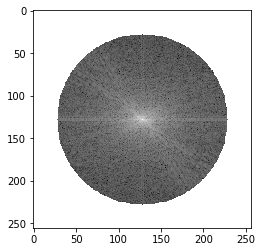

/Users/sanketh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


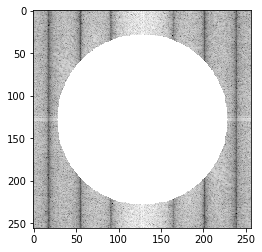

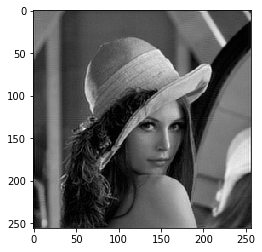

In [214]:
def truncated_inverse_filter(inputs, PSF):
    input_fft = fftshift(fft2(inputs))
    PSF_fft = fftshift(fft2(PSF))
    input_fft_scaled = input_fft/input_fft.max()
    PSF_fft_scaled = PSF_fft/PSF_fft.max()
    recovered_fft_scaled = input_fft_scaled/PSF_fft_scaled
    recovered_fft = recovered_fft_scaled*input_fft.max()
    circle_img = np.zeros(input_fft.shape)
    cv2.circle(circle_img,(input_fft.shape[0]//2,input_fft.shape[1]//2),100,1,thickness=-1)
    plt.figure()
    plt.imshow(circle_img)
    plt.show()
    inner_recovered_fft = circle_img*recovered_fft
    plt.figure()
    plt.imshow(np.log(np.abs(inner_recovered_fft)))
    plt.show()
    circle_img = 1 - circle_img
    outer_input_fft = circle_img*input_fft
    plt.figure()
    plt.imshow(np.log(np.abs(outer_input_fft)))
    plt.show()
    result = ifftshift(ifft2(inner_recovered_fft+outer_input_fft))
    result = numpy.abs(result)
    return result

psf_motion_blur = motion_process(leng=7, size=image.shape)

motion_blurred_image = make_blurred(image, psf_motion_blur)

truncated_deblurred_motion_image = truncated_inverse_filter(motion_blurred_image, psf_motion_blur)

plt.figure()
plt.imshow(truncated_deblurred_motion_image)
plt.show()